In [1]:
%gui qt5

In [59]:
from thermosteam import functional as fn # Useful functions for building chemicals
import biosteam as bst


# %% Define common chemicals
chemicals = bst.Chemicals(
    ['Water', 'Ethanol', 'Glucose', 'Sucrose',
     'H3PO4', 'P4O10', 'CO2', 'Octane', 'O2'])

(Water,  Ethanol, Glucose, Sucrose,
 H3PO4, P4O10, CO2, Octane, O2) = chemicals

O2.at_state(phase='g')
CO2.at_state(phase='g')
H3PO4.at_state(phase='s')
P4O10.at_state(phase='s')
Glucose.at_state(phase='s')
Sucrose.at_state(phase='s')

# %% Define new chemicals

def create_new_chemical(ID, phase='s', **constants):
    solid = bst.Chemical.blank(ID, phase=phase, **constants)
    chemicals.append(solid)
    return solid

Ash = create_new_chemical('Ash', MW=1.)
Cellulose = create_new_chemical('Cellulose',
                                formula="C6H10O5", # Glucose monomer minus water
                                Hf=-975708.8)
Hemicellulose = create_new_chemical('Hemicellulose',
                                    formula="C5H8O5", # Xylose monomer minus water
                                    Hf=-761906.4)
Flocculant = create_new_chemical('Flocculant',
                                 MW=1.)
Lignin = create_new_chemical('Lignin',
                             formula='C8H8O3', # Vainillin formula
                             Hf=-452909.632)

Solids = create_new_chemical('Solids', MW=1.)
DryYeast = create_new_chemical('DryYeast', MW=1., CAS='Yeast')
CaO = create_new_chemical('CaO', formula='CaO')

# %% Fill missing properties

# Insolubles occupy a significant volume
insoluble_solids = (Ash, Cellulose, Hemicellulose,
                    Flocculant, Lignin, Solids, DryYeast, P4O10)

# Solubles don't occupy much volume
soluble_solids = (CaO, H3PO4, Glucose, Sucrose)

for chemical in insoluble_solids:
    V = fn.rho_to_V(rho=1540, MW=chemical.MW)
    chemical.V.add_model(V, top_priority=True)

for chemical in soluble_solids:
    V = fn.rho_to_V(rho=1e5, MW=chemical.MW)
    chemical.V.add_model(V, top_priority=True)

# Add constant models for molar heat capacity of solids
Ash.Cn.add_model(0.09 * 4.184 * Ash.MW)
CaO.Cn.add_model(1.02388 * CaO.MW)
Cellulose.Cn.add_model(1.364 * Cellulose.MW)
Hemicellulose.Cn.add_model(1.364 * Hemicellulose.MW)
Flocculant.Cn.add_model(4.184 * Flocculant.MW)
Lignin.Cn.add_model(1.364 * Lignin.MW)
Solids.Cn.add_model(1.100 * Solids.MW)

for chemical in chemicals:
    chemical.default()

chemicals.compile()
chemicals.set_synonym('Water', 'H2O')

bst.settings.set_thermo(chemicals)

In [58]:
bst.CE = 567 # 2013
bst.PowerUtility.price = 0.065
HeatUtility = bst.HeatUtility
# Steam is produced on-site by a boiler,
# so make it the only available heating agent.
steam_utility = HeatUtility.get_agent('high_pressure_steam')
HeatUtility.heating_agents = [steam_utility]
steam_utility.heat_transfer_efficiency = 0.85
steam_utility.regeneration_price = 0.30626
steam_utility.T = 529.2
steam_utility.P = 44e5

# Cooling water and chilled water are regenerated by
# on-site facilities. The regeneration and heat transfer
# prices are given accounted for by the capital cost and
# electricity consumption of these facilities
HeatUtility.get_agent('cooling_water').regeneration_price = 0
HeatUtility.get_agent('chilled_water').heat_transfer_price = 0

# Raw material price (USD/kg)
price = {'Sugar cane': 0.03455, # 70% m.c
         'Water': 0.000353,
         'HCl': 0.205,
         'Lime': 0.077,
         'H3PO4': 0, # Not significant
         'NaOH':0.41,
         'Protease': 0.5,
         'Polymer': 0, # Not significant
         'Steam': 0.017,
         'Ethanol': 0.789,
         'Waste': -0.33,
         'Gasoline': 0.756} # 2 USD/gal

HXutility: H201
ins...
[0] missing stream
outs...
[0] s281
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0


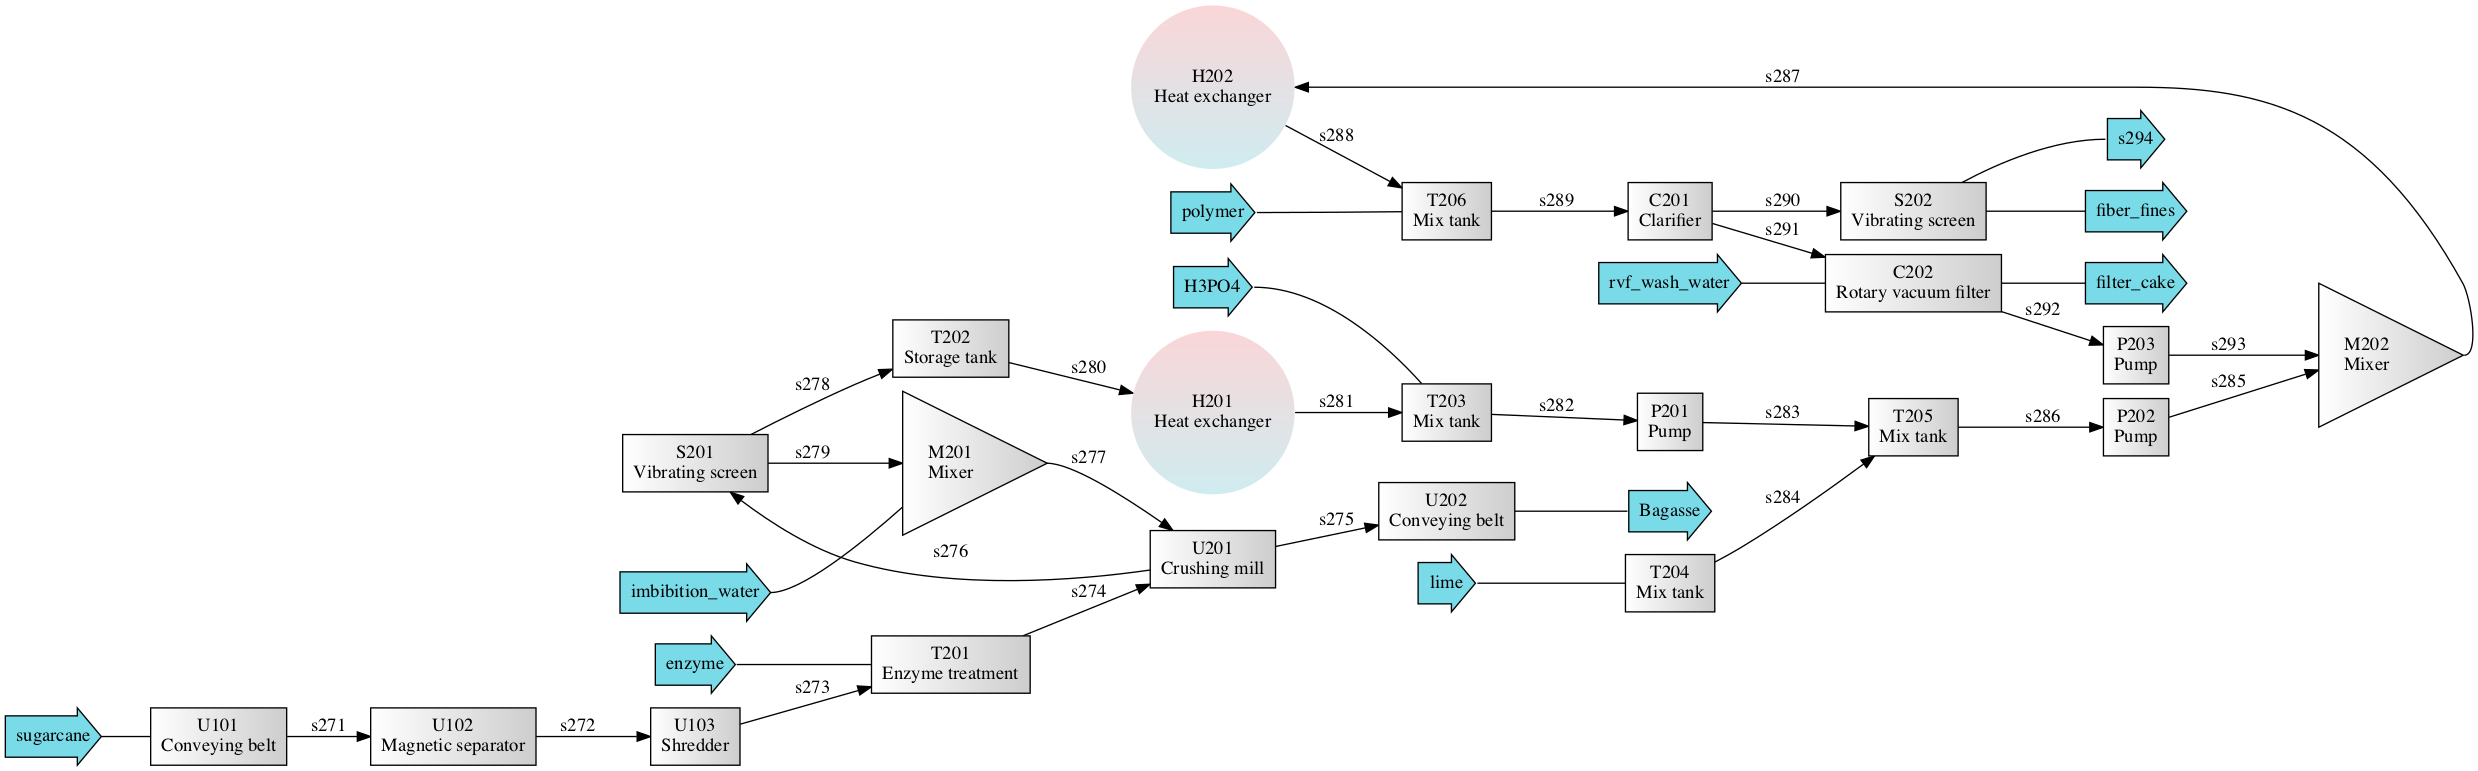

System: sugarcane_pretreatment_sys
 path: (U101, U102, U103, T201, SYS27,
        T202, H201, T203, P201, T204,
        T205, P202, SYS28, S202, U202)


In [61]:
from biosteam import units
import numpy as np

bst.main_flowsheet.set_flowsheet('sugarcane_pretreatment_section')

z_mass_sugarcane = chemicals.kwarray(
    dict(Glucose=0.0120811,
         Lignin=0.0327653,
         Solids=0.015,
         Sucrose=0.136919,
         Ash=0.006,
         Cellulose=0.0611531,
         Hemicellulose=0.036082,
         Water=0.7)
)

sugarcane = bst.Stream('sugarcane',
                       flow=333334 * z_mass_sugarcane,
                       units='kg/hr',
                       price=price['Sugar cane'])

enzyme = bst.Stream('enzyme',
                    Cellulose=100, Water=900, units='kg/hr',
                    price=price['Protease'])

imbibition_water = bst.Stream('imbibition_water',
                              Water=87023.35, units='kg/hr',
                              T = 338.15)

H3PO4 = bst.Stream('H3PO4',
                   H3PO4=74.23, Water=13.10, units='kg/hr',
                   price=price['H3PO4'])  # to T203

lime = bst.Stream('lime',
                  CaO=333.00, Water=2200.00, units='kg/hr',
                  price=price['Lime'])  # to P5

polymer = bst.Stream('polymer',
                     Flocculant=0.83, units='kg/hr',
                     price=price['Polymer'])  # to T205

rvf_wash_water = bst.Stream('rvf_wash_water',
                            Water=16770, units='kg/hr',
                            T=363.15)  # to C202

### Unit operations ###

# Feed the shredder
U101 = units.ConveyingBelt('U101', ins=sugarcane)

# Separate metals
U102 = units.MagneticSeparator('U102', ins=U101-0)

# Shredded cane
U103 = units.Shredder('U103', ins=U102-0)

# Hydrolyze starch
T201 = units.EnzymeTreatment('T201', T=323.15)  # T=50

# Finely crush lipid cane
U201 = units.CrushingMill('U201',
                          split=dict(Ash=0.92,
                                     Cellulose=0.92,
                                     Glucose=0.04,
                                     Hemicellulose=0.92,
                                     Lignin=0.92,
                                     Sucrose=0.04,
                                     Solids=1),
                          moisture_content=0.5)

# Convey out bagasse
U202 = units.ConveyingBelt('U202', ins=U201.outs[0], outs='Bagasse')

# Mix in water
M201 = units.Mixer('M201')
# crushing_mill_recycle_sys = bst.System('crushing_mill_recycle_sys',
#                                path=(U201, S201, M201),
#                                recycle=M201-0)

# Screen out fibers
S201 = units.VibratingScreen('S201',
                             split=dict(Ash=0.35,
                                        Cellulose=0.35,
                                        Glucose=0.88,
                                        Hemicellulose=0.35,
                                        Lignin=0.35,
                                        Solids=0,
                                        Sucrose=0.88,
                                        Water=0.88))

# Store juice before treatment
T202 = units.StorageTank('T202', tau=4, vessel_material='Carbon steel')

# Heat up before adding acid
H201 = units.HXutility('H201', T=343.15)

H201.show()
# Mix in acid
T203 = units.MixTank('T203')

# Pump acid solution
P201 = units.Pump('P201')

# Mix lime solution
T204 = units.MixTank('T204', tau=0.10)
P202 = units.Pump('P202')

# Blend acid lipid solution with lime
T205 = units.MixTank('T205', tau=0.10)

# Mix recycle
M202 = units.Mixer('M202')

# Heat before adding flocculant
H202 = units.HXutility('H202', T=372.15)

# Mix in flocculant
T206 = units.MixTank('T206')
T206.tau = 0.10

# Separate residual solids
C201 = units.Clarifier('C201',
                       split=dict(Ash=0,
                                  CaO=0,
                                  Cellulose=0,
                                  Flocculant=0.522,
                                  Glucose=0.522,
                                  Hemicellulose=0,
                                  Lignin=0,
                                  H3PO4=0.522,
                                  Sucrose=0.522,
                                  Water=0.522))

# Remove solids as filter cake
C202 = units.RVF('C202',
                 outs=('filter_cake', ''),
                 moisture_content=0.80,
                 split=dict(Ash=0.85,
                            CaO=0.85,
                            Cellulose=0.85,
                            Glucose=0.01,
                            Hemicellulose=0.85,
                            Lignin=0.85,
                            Sucrose=0.01))
P203 = units.Pump('P203')


# Screen out small fibers from sugar stream
S202 = units.VibratingScreen('S202', outs=('', 'fiber_fines'),
                             split=dict(Ash=1.0,
                                        CaO=1.0,
                                        Cellulose=1.0,
                                        Flocculant=0.0,
                                        Glucose=0.998,
                                        Hemicellulose=1.0,
                                        Lignin=1.0,
                                        H3PO4=1.0,
                                        Sucrose=0.998,
                                        Water=0.998))
S202.mesh_opening = 2

### Process specifications ###

# Specifications dependent on lipid cane flow rate
def correct_flows():
    U103._run()
    F_mass = sugarcane.F_mass
    # correct enzyme, lime, phosphoric acid, and imbibition water
    enzyme.imass['Cellulose', 'Water'] = 0.003 * F_mass * np.array([0.1, 0.9])
    lime.imass['CaO', 'Water'] = 0.001 * F_mass * np.array([0.046, 0.954])
    H3PO4.imass['H3PO4', 'Water'] = 0.00025 * F_mass
    imbibition_water.imass['Water'] = 0.25* F_mass

U103.specification = correct_flows

# Specifications within a system
def correct_wash_water():
    P202._run()
    solids = P202.outs[0].imol['Ash', 'CaO', 'Cellulose',
                               'Hemicellulose', 'Lignin'].sum()
    rvf_wash_water.imol['Water'] = 0.0574 * solids

P202.specification = correct_wash_water

### System set-up ###

(U103-0, enzyme)-T201
(T201-0, M201-0)-U201-1-S201-0-T202
(S201-1, imbibition_water)-M201

T202-0-H201
(H201-0, H3PO4)-T203-P201
(P201-0, lime-T204-0)-T205-P202
(P202-0, P203-0)-M202-H202
(H202-0, polymer)-T206-C201
(C201-1, rvf_wash_water)-C202-1-P203
C201-0-S202


# Note that internal recycle systems are automatically created
sugarcane_pretreatment_sys = bst.main_flowsheet.create_system('sugarcane_pretreatment_sys')
sugarcane_pretreatment_sys.diagram('thorough')
sugarcane_pretreatment_sys.show()

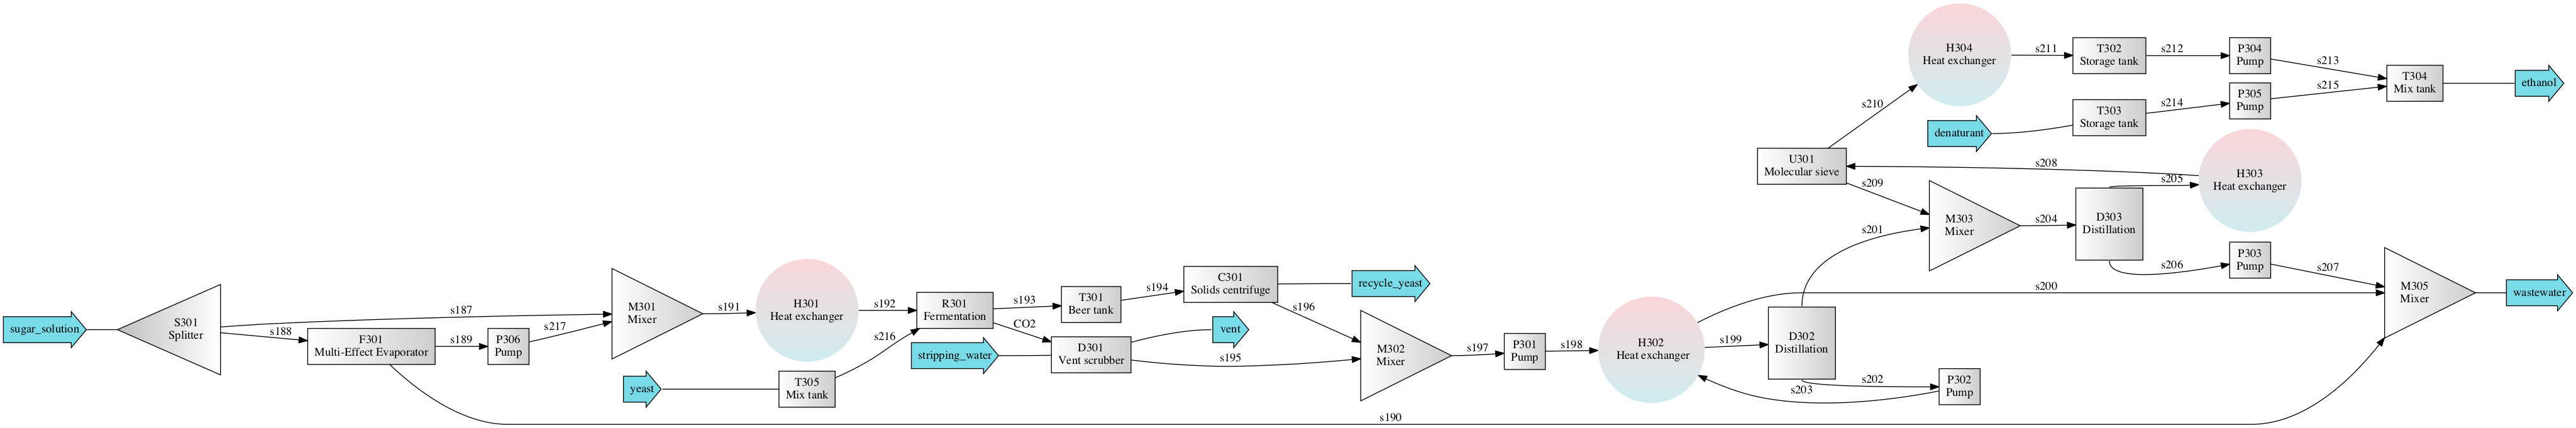

System: ethanol_production_sys
 path: (S301, F301, P306, M301, H301, T305,
        R301, T301, C301, M302, P301,
        SYS19, SYS20, H304, T302, P304,
        T303, P305, T304, D301, P303, M305)


In [37]:
bst.main_flowsheet.set_flowsheet('sugarcane_ethanol_production_section')

### Helpful functions ###

def mass2molar_ethanol_fraction(x):
    """Return ethanol mol fraction in a ethanol water mixture"""
    return x/46.06844 / (x/46.06844 + (1-x)/18.01528)

### Streams ###

# Fresh water
stripping_water = bst.Stream('stripping_water', Water=5000, units='kg/hr')

# Gasoline
denaturant = bst.Stream('denaturant', Octane=230.69,
                        units='kg/hr', price=price['Gasoline'])

sugar_solution = bst.Stream('sugar_solution',
    Glucose = 3802,
    Sucrose = 4.309e+04,
    Water   = 2.59e+05,
    H3PO4   = 83.33,
    units = 'kg/hr',
    T = 372,
)

# Yeast
yeast = bst.Stream('yeast', Water=24700, DryYeast=10300, units='kg/hr')

# Ethanol product
ethanol = bst.Stream('ethanol', price=price['Ethanol'])

### Units ###

# Split sugar solution
S301 = units.Splitter('S301',
                    split=0.265)

# Concentrate sugars
F301 = units.MultiEffectEvaporator('F301',
                                   P=(101325, 73581, 50892, 32777),
                                   V=0.95) # fraction evaporated
F301.components['condenser'].U = 1.85
# Note: value of steam ~ 6.86 for the following
# (101325, 73580.467, 50891.17, 32777.406, 19999.925, 11331.5),

# Mix sugar solutions
M301 = units.Mixer('M301')

# Cool for fermentation
H301 = units.HXutility('H301', T=295.15)

# Ethanol Production
R301 = units.Fermentation('R301', outs=('CO2', ''), tau=9, efficiency=0.90, N=4)
T301 = units.StorageTank('T301', tau=4, vessel_material='Carbon steel')
T301.line = 'Beer tank'

D301 = units.VentScrubber('D301', ins=(stripping_water, R301-0),
                          outs=('vent', ''),
                          gas=('CO2',))

# Separate 99% of yeast
C301 = units.SolidsCentrifuge('C301', outs=('', 'recycle_yeast'),
                            split=(1, 0.99999, 1, 0.96, 0.01),
                            order=('Ethanol', 'Glucose', 'H3PO4',
                                   'Water', 'DryYeast'),
                            solids=('DryYeast',))

# Mix in Water
M302 = units.Mixer('M302')
P301 = units.Pump('P301')

# Heat up before beer column
# Exchange heat with stillage
H302 = units.HXprocess('H302', phase0='l', phase1='l', U=1.28)

# Beer column
xbot = mass2molar_ethanol_fraction(0.00001)
ytop = mass2molar_ethanol_fraction(0.574)
D302 = units.BinaryDistillation('D302', P=101325,
                            y_top=ytop, x_bot=xbot, k=1.25,
                            LHK=('Ethanol', 'Water'))
D302.tray_material = 'Stainless steel 304'
D302.vessel_material = 'Stainless steel 304'
D302.boiler.U = 1.85
P302 = units.Pump('P302')

# Mix ethanol Recycle (Set-up)
M303 = units.Mixer('M303')

ytop = mass2molar_ethanol_fraction(0.9061726)
D303 = units.BinaryDistillation('D303', P=101325,
                            y_top=ytop, x_bot=xbot, k=1.25,
                            LHK=('Ethanol', 'Water'),
                            tray_material='Stainless steel 304',
                            vessel_material='Stainless steel 304',
                            is_divided=True)
D303.boiler.U = 1.85
P303 = units.Pump('P303')

# Superheat vapor for mol sieve
H303 = units.HXutility('H303', T=115+273.15, V=1)

# Molecular sieve
U301 = units.MolecularSieve('U301',
                            split=(2165.14/13356.04, 1280.06/1383.85),
                            order=('Ethanol', 'Water'))

# Condense ethanol product
H304 = units.HXutility('H304', 'S149', V=0, T=340.)
T302 = units.StorageTank('T302', tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P304 = units.Pump('P304')

# Storage for gasoline
T303 = units.StorageTank('T303', tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P305 = units.Pump('P305')

# Denatured ethanol product
T304 = units.MixTank('T304', outs=ethanol)
T304.tau = 0.10

# Waste water
M305 = units.Mixer('M305', outs='wastewater')

# Yeast mixing
T305 = units.MixTank('T305')
T305.tau = 0.1
yeast-T305

# Multi-effect evaporator pumps
P306 = units.Pump('P306')


### Ethanol system set-up ###

sugar_solution-S301-1-F301-0-P306
(S301-0, P306-0)-M301-H301
(H301-0, yeast-T305-0)-R301-1-T301-0-C301
(C301-0, D301-1)-M302-P301
(P301-0, P302-0)-H302-0-D302-1-P302
(D302-0, U301-0)-M303-0-D303-0-H303-U301
D303-1-P303

def adjust_denaturant():
    P304._run()
    pure_ethanol = P304.outs[0]
    denaturant.imol['Octane'] = 0.021*pure_ethanol.F_mass/114.232

P304.specification = adjust_denaturant
U301-1-H304-0-T302-0-P304
denaturant-T303-P305
(P305-0, P304-0)-T304
(P303-0, F301-1, H302-1)-M305

# Here we create the a system of the ethanol section just to view
# the diagram for this section, but its not important to complete TEA.
ethanol_production_sys = bst.main_flowsheet.create_system('ethanol_production_sys')
ethanol_production_sys.diagram('thorough')
ethanol_production_sys.show()

In [50]:
s = bst.main_flowsheet.stream
HeatUtility = bst.HeatUtility
steam_utility_low = HeatUtility.get_agent('high_pressure_steam')

BT = units.BoilerTurbogenerator('BT', (U202-0, '', 'boiler_makeup_water', 'natural_gas', '', ''), boiler_efficiency=0.80, turbogenerator_efficiency=0.85, agent = steam_utility)






CT = units.CoolingTower('CT')


makeup_water_streams = (s.cooling_tower_makeup_water,
                        s.boiler_makeup_water)
process_water_streams = (imbibition_water,
                         rvf_wash_water,
                         stripping_water,
                         *makeup_water_streams)
makeup_water = bst.Stream('makeup_water', price=0.000254)

CWP = units.ChilledWaterPackage('CWP')
PWC = units.ProcessWaterCenter('PWC',
                               (bst.Stream(), makeup_water),
                               (),
                               None,
                               makeup_water_streams,
                               process_water_streams)


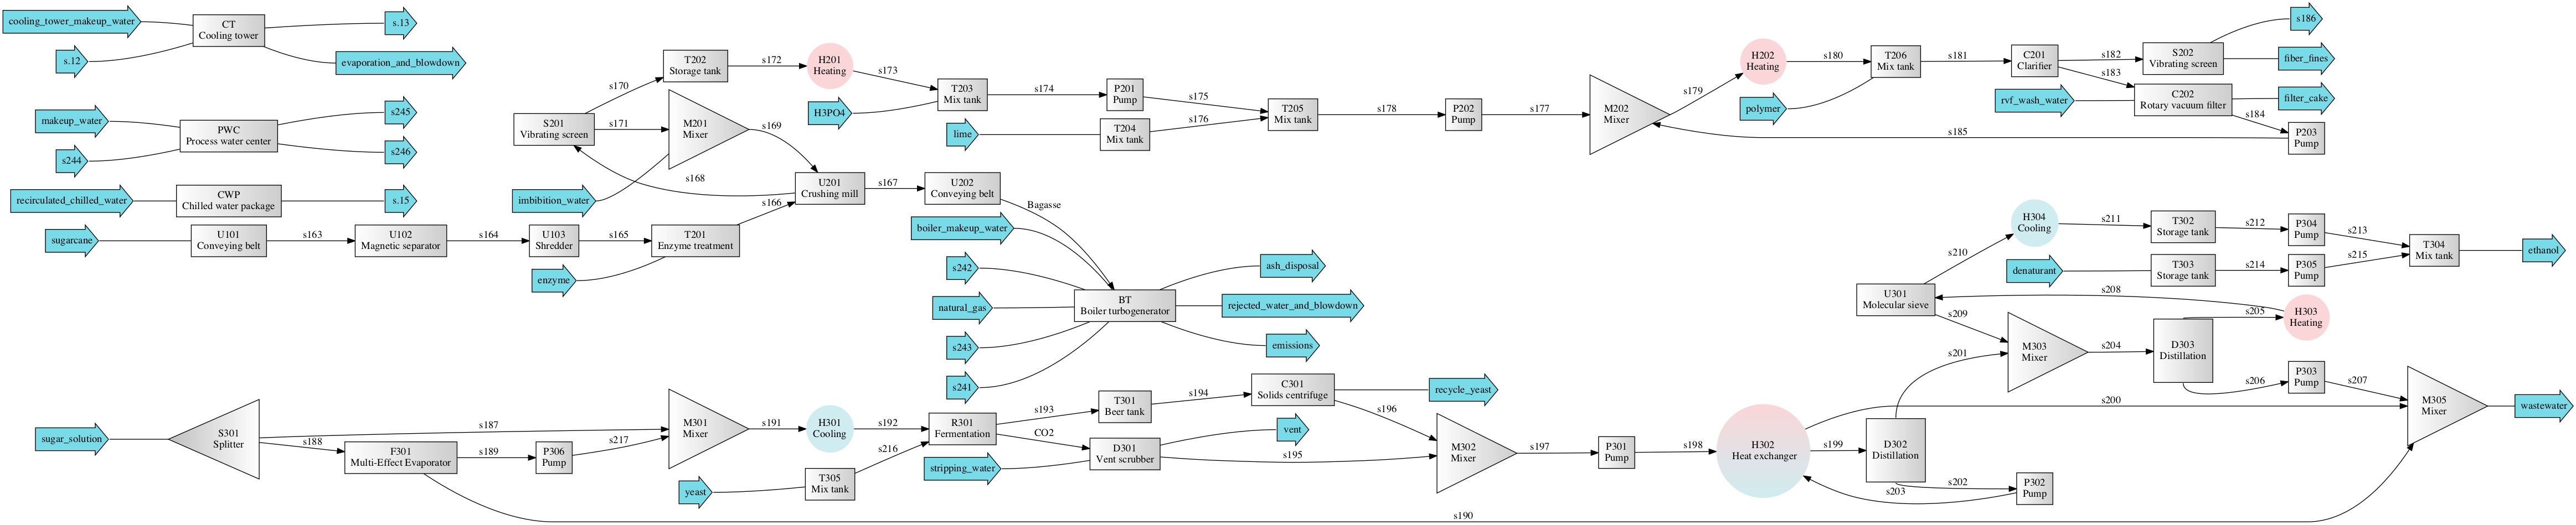

System: sugarcane_sys
 path: (U101, U102, U103, T201, SYS21,
        T202, H201, T203, P201, T204,
        T205, P202, SYS22, S202, U202,
        S301, F301, P306, M301, H301,
        T305, R301, T301, C301, M302,
        P301, SYS23, SYS24, H304, T302,
        P304, T303, P305, T304, D301,
        P303, M305)
 facilities: (BT, CWP, CT, PWC)


In [51]:
# First create a joint flowsheet
sugarcane_flowsheet = bst.main_flowsheet.from_flowsheets(
    'sugarcane_flowsheet',
    ['sugarcane_pretreatment_section',
     'sugarcane_ethanol_production_section'])
sugarcane_sys = sugarcane_flowsheet.create_system('sugarcane_sys')
sugarcane_sys.simulate()
sugarcane_sys.diagram('thorough')
sugarcane_sys.show()

In [53]:
class SugarcaneTEA(bst.TEA):
    """
    Create a SugarcaneTEA object for techno-economic analysis of a biorefinery [1]_.

    Parameters
    ----------
    system : System
        Should contain feed and product streams.
    IRR : float
        Internal rate of return (fraction).
    duration : tuple[int, int]
        Start and end year of venture (e.g. (2018, 2038)).
    depreciation : str
        'MACRS' + number of years (e.g. 'MACRS7').
    operating_days : float
        Number of operating days per year.
    income_tax : float
        Combined federal and state income tax rate (fraction).
    lang_factor : float
        Lang factor for getting fixed capital investment from
        total purchase cost. If no lang factor, estimate capital investment
        using bare module factors.
    startup_schedule : tuple[float]
        Startup investment fractions per year
        (e.g. (0.5, 0.5) for 50% capital investment in the first year and 50%
        investment in the second).
    WC_over_FCI : float
        Working capital as a fraction of fixed capital investment.
    labor_cost : float
        Total labor cost (USD/yr).
    fringe_benefits : float
        Cost of fringe benefits as a fraction of labor cost.
    property_tax : float
        Fee as a fraction of fixed capital investment.
    property_insurance : float
        Fee as a fraction of fixed capital investment.
    supplies : float
        Yearly fee as a fraction of labor cost.
    maintenance : float
        Yearly fee as a fraction of fixed capital investment.
    administration : float
        Yearly fee as a fraction of fixed capital investment.

    References
    ----------
    .. [1] Huang, H., Long, S., & Singh, V. (2016). Techno-economic analysis of biodiesel
        and ethanol co-production from lipid-producing sugarcane. Biofuels, Bioproducts
        and Biorefining, 10(3), 299–315. https://doi.org/10.1002/bbb.1640

    """

    __slots__ = ('labor_cost', 'fringe_benefits', 'maintenance',
                 'property_tax', 'property_insurance', '_FCI_cached',
                 'supplies', 'maintanance', 'administration')

    def __init__(self, system, IRR, duration, depreciation, income_tax,
                 operating_days, lang_factor, construction_schedule, WC_over_FCI,
                 labor_cost, fringe_benefits, property_tax,
                 property_insurance, supplies, maintenance, administration):
        super().__init__(system, IRR, duration, depreciation, income_tax,
                         operating_days, lang_factor, construction_schedule,
                         startup_months=0, startup_FOCfrac=0, startup_VOCfrac=0,
                         startup_salesfrac=0, finance_interest=0, finance_years=0,
                         finance_fraction=0, WC_over_FCI=WC_over_FCI)
        self.labor_cost = labor_cost
        self.fringe_benefits = fringe_benefits
        self.property_tax = property_tax
        self.property_insurance = property_insurance
        self.supplies= supplies
        self.maintenance = maintenance
        self.administration = administration

    def _DPI(self, installed_equipment_cost):
        return installed_equipment_cost

    def _TDC(self, DPI):
        return DPI

    def _FCI(self, TDC):
        self._FCI_cached = TDC
        return TDC

    def _FOC(self, FCI):
        return (FCI*(self.property_tax + self.property_insurance
                     + self.maintenance + self.administration)
                + self.labor_cost*(1+self.fringe_benefits+self.supplies))

sugarcane_tea = SugarcaneTEA(system=sugarcane_sys,
                             IRR=0.15,
                             duration=(2018, 2038),
                             depreciation='MACRS7',
                             income_tax=0.35,
                             operating_days=200,
                             lang_factor=3,
                             construction_schedule=(0.4, 0.6),
                             WC_over_FCI=0.05,
                             labor_cost=2.5e6,
                             fringe_benefits=0.4,
                             property_tax=0.001,
                             property_insurance=0.005,
                             supplies=0.20,
                             maintenance=0.01,
                             administration=0.005)

sugarcane_tea.IRR = sugarcane_tea.solve_IRR()
sugarcane_tea.show()

SugarcaneTEA: sugarcane_sys
 NPV: 0 USD at 10.3% IRR


In [54]:
UnitGroup = bst.process_tools.UnitGroup
# Every unit class has a 'line' attribute that denotes
# what type of unit it is. For example, the line of both
# the BinaryDistillation and the ShortcutColumn is 'Distillation'.
# Grouping units by line is just a easy way of grouping units.
groups_by_line = UnitGroup.group_by_lines(sugarcane_tea.units)
UnitGroup.df_from_groups(groups_by_line, with_electricity_production=True)

,Installed equipment cost [MM$],Cooling duty [GJ/hr],Heating duty [GJ/hr],Electricity consumption [MW],Electricity production [MW]
Beer tank,0.188,0,0,0,0
Boiler turbogenerator,72.8,23.7,0,1.08,37.4
Chilled water package,1.86,48.6,0,2.1,0
Clarifier,0.232,0,0,0.000598,0
Conveying belt,0.157,0,0,0.00976,0
Cooling tower,1.45,0,0,0.951,0
Crushing mill,4.38,0,0,2.78,0
Distillation,4.11,82.6,135,0,0
Enzyme treatment,1.98,0,32.5,0.0296,0
Fermentation,2.68,21.2,0,0.0143,0


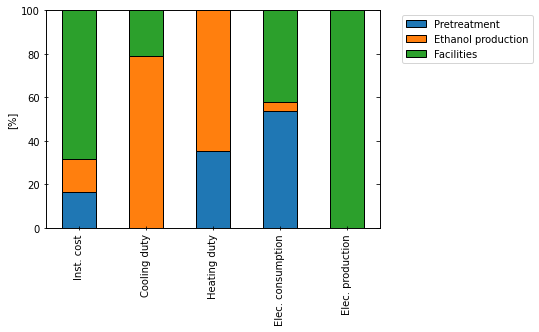

In [56]:
# It is also possible to group units manually
units_with_costs = bst.process_tools.units_with_costs
pretreatment = UnitGroup('Pretreatment', units_with_costs(sugarcane_pretreatment_sys.units))
ethanol_production = UnitGroup('Ethanol production', units_with_costs(ethanol_production_sys.units))
facilities = UnitGroup('Facilities', sugarcane_sys.facilities)
groups = [pretreatment, ethanol_production, facilities]
UnitGroup.df_from_groups(groups, with_electricity_production=True)


UnitGroup.plot_bars_from_groups(groups, with_electricity_production=True)
